# 🔩 Boilerplate

In [1]:
# Imports
import os
import random
import matplotlib.pyplot as plt
import cv2
import torch

from yolo_to_coco import convert_yolo_to_coco

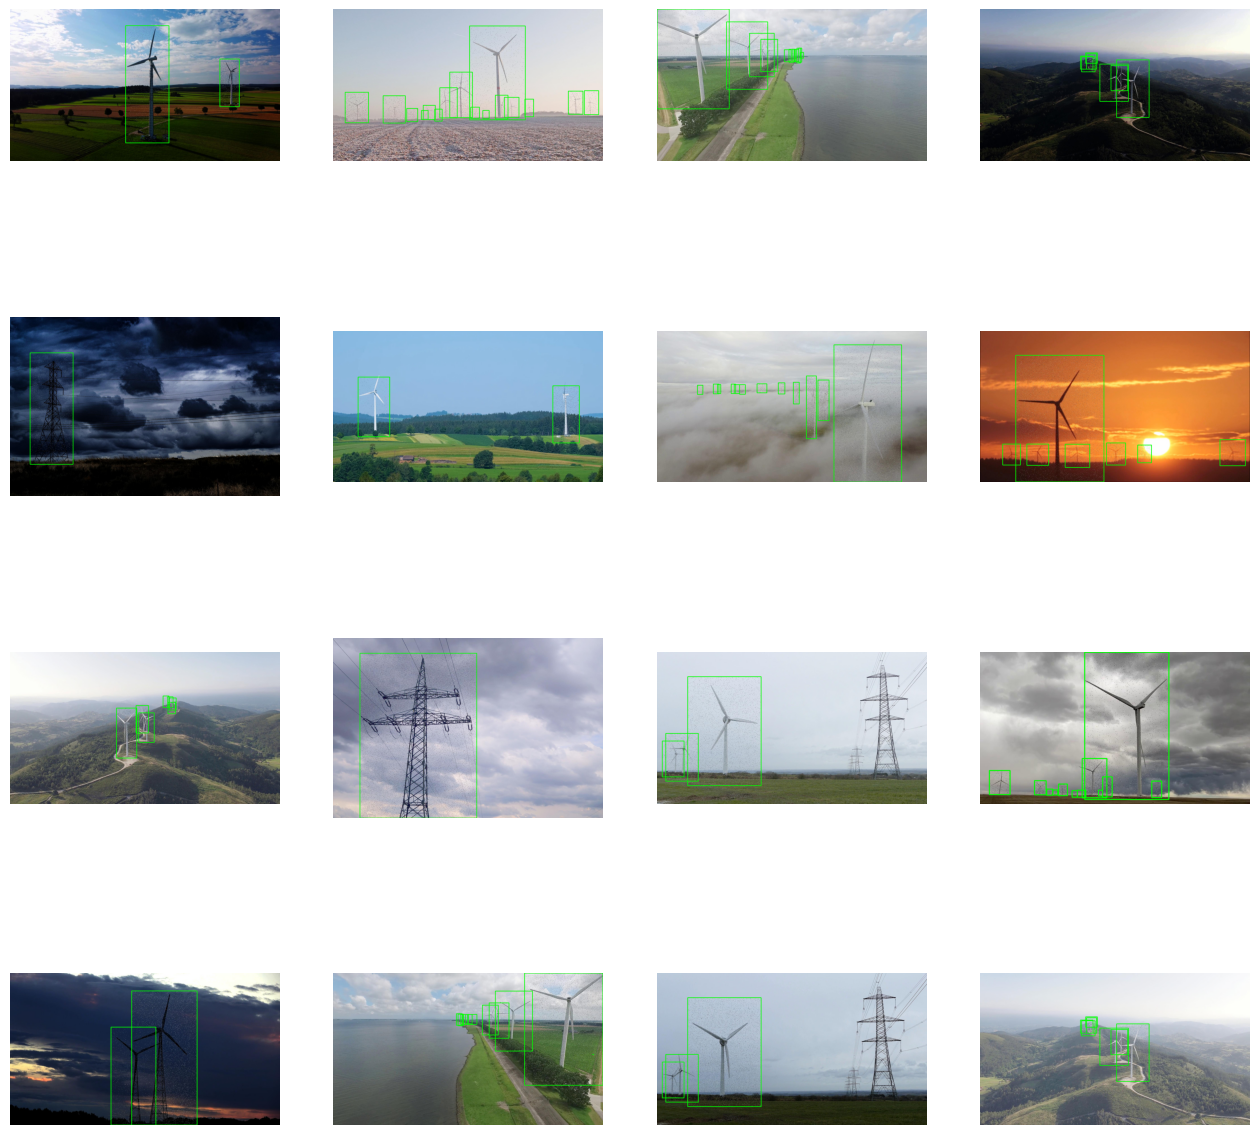

In [2]:
# Download the dataset here: https://www.kaggle.com/datasets/kylegraupe/wind-turbine-image-dataset-for-computer-vision?resource=download

# Define the paths to the images and labels directories
train_images = "data/train/images"
train_labels = "data/train/labels"

test_images = "data/test/images"
test_labels = "data/test/labels"

val_images = "data/valid/images"
val_labels = "data/valid/labels"

# Get a list of all the image files in the training images directory
image_files = os.listdir(train_images)

# Choose 16 random image files from the list
random_images = random.sample(image_files, 16)

# Set up the plot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Loop over the random images and plot the object detections
for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4

    # Load the image
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    # Load the labels for this image
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    # Loop over the labels and plot the object detections
    # Loop over the labels and plot the object detections
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)


    # Show the image with the object detections
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()

# 💾 Convert data from YOLO to COCO format

In [4]:
train_dir = "data/train"
val_dir = "data/valid"
test_dir = "data/test"
output_path = "data/coco"

dirs = [train_dir, val_dir, test_dir]

for dir in dirs:
    output_json_file = os.path.join(output_path, os.path.basename(dir) + ".json")
    convert_yolo_to_coco(dir, output_json_file)

#### Check if the data preprocessing is correct

In [3]:
%matplotlib inline
import pycocotools.coco as coco
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [4]:
data_dir = "data/coco/"
data_type = "train/images"
ann_file = f"{data_dir}annotations/train.json"

In [5]:
# initialize COCO api for instance annotations
coco = COCO(ann_file)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [6]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())

nms = [cat["name"] for cat in cats]
print("Categories: {}".format(nms))

nms = set([cat["supercategory"] for cat in cats if cat.get("supercategory") is not None])
print("Super-categories: {}".format(nms))

Categories: ['windmill']
Super-categories: set()


Image n°914
Image name: data/train/images/windmill53_jpg.rf.f8fff8eddce52450410576eb8ac4225a.jpg


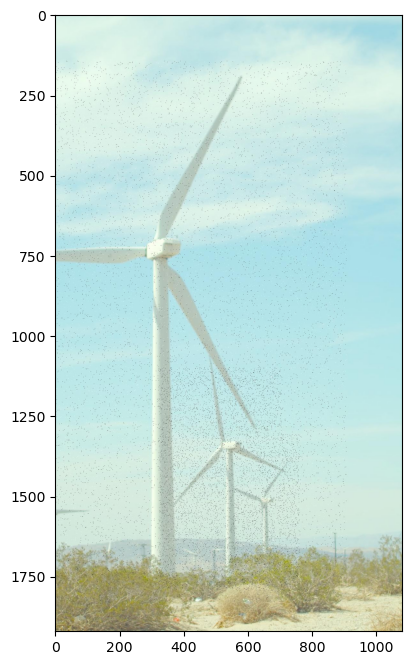

In [11]:
# load and display image
catIds = coco.getCatIds(catNms=["windmill"])
imgIds = coco.getImgIds(catIds=catIds)

img_id = imgIds[np.random.randint(0, len(imgIds))]
print("Image n°{}".format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = "data/%s/%s" % (data_type, img["file_name"])
print("Image name: {}".format(img_name))

I = io.imread(img_name)
plt.figure()
plt.imshow(I)

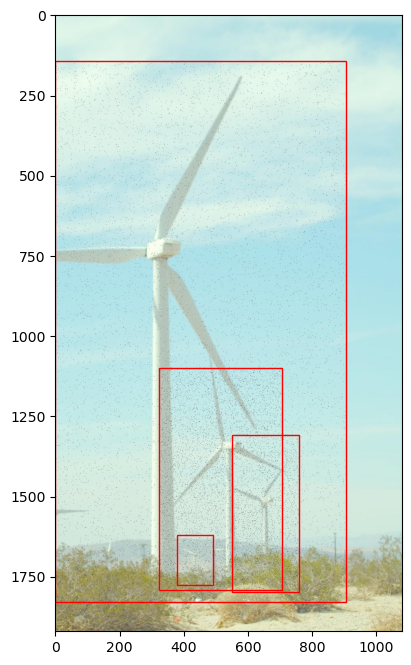

In [12]:
from draw_bbox import draw_bounding_boxes

anns = coco.loadAnns(coco.getAnnIds(imgIds=img["id"], catIds=catIds, iscrowd=None))

# Assuming 'I' is your image loaded as a numpy array
# and 'anns' is the list of annotations for that image
draw_bounding_boxes(I, anns)

# 🚵 Model Training

In [5]:
# Clone repo for finetuning DETR on a custom dataset with one class
!rm -rf detr
!git clone https://github.com/woctezuma/detr.git

%cd detr/

!git checkout finetune

%cd ../

[Errno 2] No such file or directory: '/content/'
/Users/dbchristenson/Desktop/uchicago/Fourth Year/compvis/windmill_object_detection/src
Cloning into 'detr'...
remote: Enumerating objects: 263, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 263 (delta 4), reused 5 (delta 3), pack-reused 253
Receiving objects: 100% (263/263), 324.61 KiB | 3.57 MiB/s, done.
Resolving deltas: 100% (126/126), done.
/Users/dbchristenson/Desktop/uchicago/Fourth Year/compvis/windmill_object_detection/src/detr
Already on 'finetune'
Your branch is up to date with 'origin/finetune'.


In [14]:
# Load the pre-trained model states
checkpoint = torch.hub.load_state_dict_from_url(
    url="https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth",
    map_location="cpu",
    check_hash=True,
)

# Remove class weights
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]

# Create models folder
!mkdir -p models

# Save
no_class_head_path = "models/detr-r50_no-class-head.pth"
torch.save(checkpoint, no_class_head_path)

In [13]:
num_classes = 1
finetuned_classes = ["windmill"]

In [17]:
os.listdir(os.getcwd())

['wind-turbines-object-detection-using-yolov8.ipynb',
 'yolo_to_coco.py',
 '.DS_Store',
 'wind-turbines-detr.ipynb',
 'models',
 '__pycache__',
 'draw_bbox.py',
 'detr',
 'data',
 'outputs']

In [14]:
!mkdir -p outputs

%cd detr/

!python main.py \
  --dataset_file "custom" \
  --coco_path "../data/coco/" \
  --output_dir "../outputs" \
  --resume "../models/detr-r50_no-class-head.pth" \
  --num_classes $num_classes \
  --epochs 10
%cd ../

/Users/dbchristenson/Desktop/uchicago/Fourth Year/compvis/windmill_object_detection/src/detr
Not using distributed mode
git:
  sha: e891373a8cab93d3719afb0acff28de94c6dc6a3, status: has uncommited changes, branch: finetune

Namespace(lr=0.0001, lr_backbone=1e-05, batch_size=2, weight_decay=0.0001, epochs=10, lr_drop=200, clip_max_norm=0.1, frozen_weights=None, backbone='resnet50', dilation=False, position_embedding='sine', enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, aux_loss=True, set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, bbox_loss_coef=5, giou_loss_coef=2, eos_coef=0.1, num_classes=1, dataset_file='../data/train/images', coco_path='../data/coco/', coco_panoptic_path=None, remove_difficult=False, output_dir='../outputs', device='cuda', seed=42, resume='../models/detr-r50_no-class-head.pth', start_epoch=0, eval=False, num_workers=2, world_size=1, dist_